# Deteccão de COVID-19 em imagens de raio-X

O objetivo deste exercício é treinar e avaliar um classificador capaz de detectar a presença de COVID-19 em imagens de raio-X.

As métricas a serem reportadas são F1 e Equal Error Rate (ERR) e seu respectivo threshold.

Note que uma das dificuldades deste exercicio será processar as imagens, que tem 1100 x 1100 pixels.

Dica: Utilize o [pyeer](https://pypi.org/project/pyeer/) para plotar o EER.

### Modelo utilizado: [NFNETs-F4](https://arxiv.org/pdf/2102.06171.pdf)
> Motivação: DeepMind lançou recentemente uma nova família de classificadores de imagem que alcançou uma nova precisão de ponta no conjunto de dados ImageNet. Esta nova família de classificadores de imagem, denominada NFNets (abreviação de Normalizer-Free Networks), atinge uma precisão comparável ao EfficientNet-B7, enquanto tem um tempo de trem 8,7x mais rápido.

> NFNets são uma família de ResNets modificados que alcançam precisões competitivas sem normalização de lote. Para fazer isso, ele aplica 3 técnicas diferentes:
* Ramificações e convoluções residuais modificadas com padronização de peso em escala
* Recorte de gradiente adaptável
* Otimização da arquitetura para maior precisão e velocidade de treinamento 

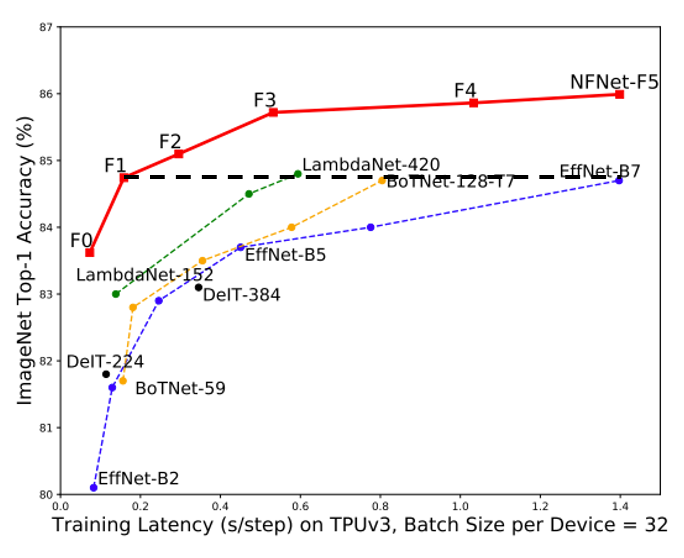

## Inicializando o Neptune

In [ ]:
! pip install -q  neptune-client==0.9.1 git+https://github.com/benjs/nfnets_pytorch pyeer

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done


In [ ]:
#!wget https://storage.googleapis.com/dm-nfnets/F4_haiku.npz

In [ ]:
import neptune.new as neptune

# Insira seu api_token para logar os resultados do treino na sua conta do Neptune.
# Como obter seu API token do Neptune:
# https://docs.neptune.ai/administration/security-and-privacy/how-to-find-and-set-neptune-api-token

run = neptune.init(project='mirelle/exercicio-7', api_token='eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiI1MmI3M2JhMi03NDQ1LTQ1YmItOTFhMy1hZjRlZjRjYmMxZjUifQ==')

https://app.neptune.ai/mirelle/exercicio-7/e/EX3-44


## Importação das bibliotecas

In [ ]:
!pip install pytorch_lightning

In [ ]:
from collections import OrderedDict
import h5py
import numpy as np

import torch
from torch.utils.data import DataLoader
from torch.optim import Optimizer
from torch import nn

import torchvision
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.metrics.functional import f1
from nfnets import pretrained_nfnet
from nfnets import SGD_AGC

#err
from pyeer.eer_info import get_eer_stats
from pyeer.report import generate_eer_report, export_error_rates
from pyeer.plot import plot_eer_stats

#report sklearn
from sklearn.metrics import classification_report

pl.utilities.seed.seed_everything(seed=123)




Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
Global seed set to 123


123

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Dataset e dataloader

### Carregamento, criação dataset e do dataloader

In [ ]:
# O download demora.
!gsutil -m cp -n gs://neuralresearcher_data/unicamp/ia376i_2021s1/data/xray_covid/* .

Skipping existing item: file://./test.hdf5
Skipping existing item: file://./train.hdf5
Skipping existing item: file://./valid.hdf5


In [ ]:
class Hdf5_Dataset(torch.utils.data.Dataset):

    def __init__(self, path, transform):

        self.h5file = h5py.File(path, 'r')        
        self.transform = transform
        self.labels = self.h5file['label']
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        label = self.h5file['label'][idx].astype(np.int64)
        img =  self.h5file['data'][idx].astype(np.uint8)
        img = self.transform(img)
        img = img.tile(3, 1, 1)
        #img = torch_equalize(img)
        #img = torch.histc(img)
      
        return img, label

In [ ]:
class CovidDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 50, num_workers: int = 2):
        super().__init__()

        self.batch_size = batch_size
        self.num_workers = num_workers
        
        size_large = (256, 256)
        size_final = (224, 224)
        '''
        self.transform = torchvision.transforms.Compose([
                  transforms.ToTensor(),
                  transforms.Resize(size=size_large),
                  torchvision.transforms.CenterCrop(224)])
        '''
        self.transform = torchvision.transforms.Compose([
              torchvision.transforms.ToTensor(),
              torchvision.transforms.Resize(size=size_final),
              #torchvision.transforms.functional.equalize,
              
              ])

    def setup(self, stage=None):

        # Assign train/val datasets for use in dataloaders
        if stage == 'fit' or stage is None:
            self.train_dataset = Hdf5_Dataset('/content/train.hdf5', transform = self.transform)
            self.val_dataset = Hdf5_Dataset('/content/valid.hdf5', transform = self.transform)

        # Assign test dataset for use in dataloader(s)
        if stage == 'test' or stage is None:
            self.test_dataset =  Hdf5_Dataset('/content/test.hdf5', transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size)

tensor([0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0])
torch.Size([20, 3, 224, 224])
torch.Size([3, 224, 224])


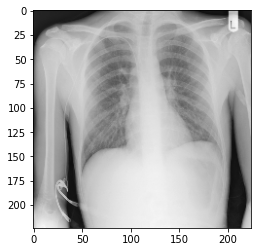

torch.Size([3, 224, 224])


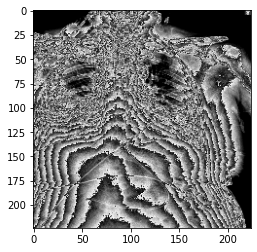

torch.Size([3, 224, 224])


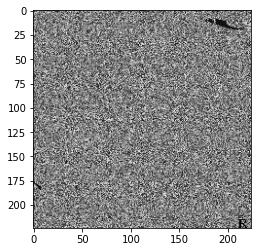

torch.Size([3, 224, 224])


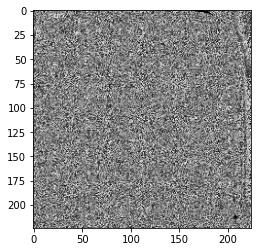

torch.Size([3, 224, 224])


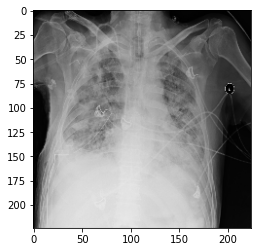

torch.Size([3, 224, 224])


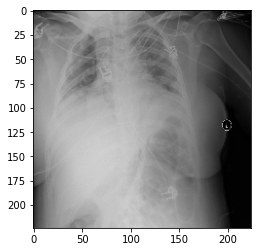

torch.Size([3, 224, 224])


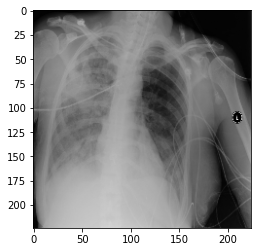

torch.Size([3, 224, 224])


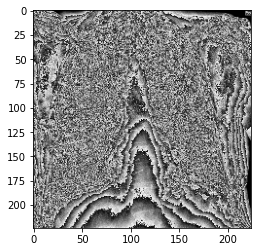

torch.Size([3, 224, 224])


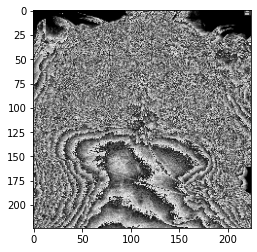

torch.Size([3, 224, 224])


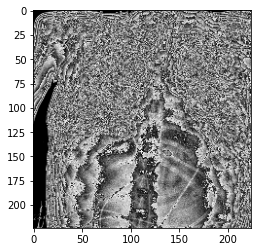

torch.Size([3, 224, 224])


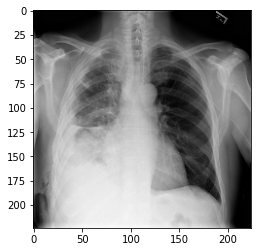

torch.Size([3, 224, 224])


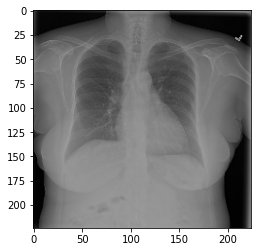

torch.Size([3, 224, 224])


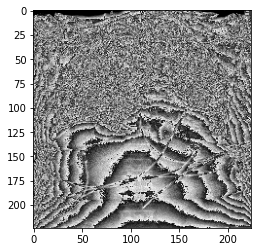

torch.Size([3, 224, 224])


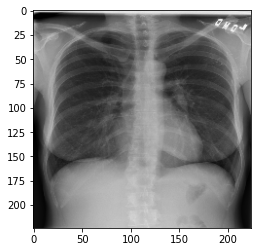

torch.Size([3, 224, 224])


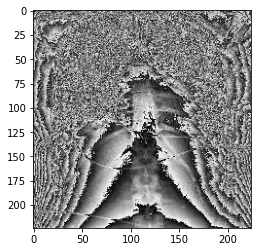

torch.Size([3, 224, 224])


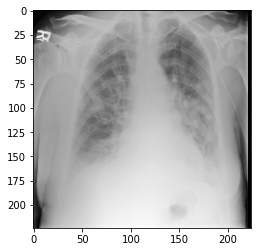

torch.Size([3, 224, 224])


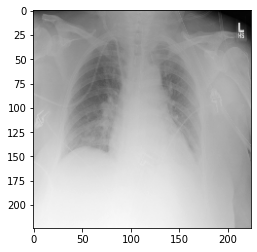

torch.Size([3, 224, 224])


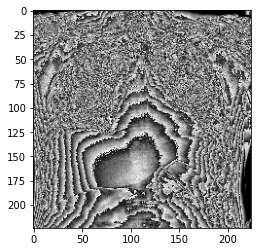

torch.Size([3, 224, 224])


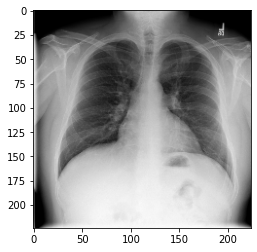

torch.Size([3, 224, 224])


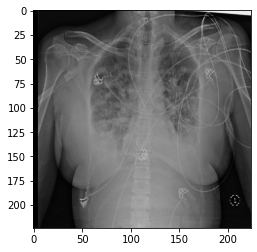

In [ ]:
dm = CovidDataModule(batch_size=20)
# To access the x_dataloader we need to call prepare_data and setup.
dm.setup()

x_train, y_train = next(iter(dm.train_dataloader()))
print(y_train)
print(x_train.shape)

#plot image
import matplotlib.pyplot as plt

for images in x_train:
    print(images.shape)
    images = images.permute(2,1,0)
    plt.figure()
    plt.imshow(images.numpy())
    plt.show()

del x_train
del y_train

### Modelo NFNET (2021)

In [ ]:
model_F4 = pretrained_nfnet('F4_haiku.npz')
print(model_F4)

NFNet(
  (activation): VPGELU()
  (stem): Stem(
    (activation): VPGELU()
    (conv0): WSConv2D(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (conv1): WSConv2D(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): WSConv2D(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (conv3): WSConv2D(64, 128, kernel_size=(3, 3), stride=(2, 2))
  )
  (body): Sequential(
    (0): NFBlock(
      (activation): VPGELU()
      (conv0): WSConv2D(128, 128, kernel_size=(1, 1), stride=(1, 1))
      (conv1): WSConv2D(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv1b): WSConv2D(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): WSConv2D(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (conv_shortcut): WSConv2D(128, 256, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_excite): SqueezeExcite(
        (activation): VPGELU()
        (linear): Linear(in_features=256, out_features=128, bias=True)
        (linear_1): Linear(in_features=128, out_features=256, bia

In [ ]:
class LitNFNetModel(pl.LightningModule):
    def __init__(self, hparams, num_classes=2):
        super().__init__()
        
        self.params = hparams
        self.best_valid_loss = 10e9
        self.num_classes = num_classes
        self.criterion = torch.nn.CrossEntropyLoss()

        # Carregando modelo pré-treinado
        self.pre_training = pretrained_nfnet('F4_haiku.npz')
        self.pre_training.linear = torch.nn.Linear(in_features=3072, out_features=self.num_classes) 

    
    # will be used during inference
    def forward(self, x):
      logits = self.pre_training(x)
      preds = logits.argmax(dim=1)
      return logits, preds

    def training_step(self, train_batch, batch_idx):
      x, y = train_batch
      logits = self.pre_training(x)

      # calcula a perda
      batch_losses = self.criterion(logits, y)
      loss = batch_losses.mean()
      run['train/batch_loss'].log(loss)

      # O PL sempre espera um retorno nomeado 'loss' da training_step.
      return {'loss': loss, 'batch_losses': batch_losses}

    def training_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()

        run['train/loss'].log(avg_loss)
        self.log('train_loss', avg_loss, on_epoch=True, prog_bar=True)
        
        return
  
    def validation_step(self, val_batch, batch_idx):
        x, y = val_batch
        
        # Transforma a entrada para duas dimensões
        # predict da rede
        logits, preds = self.forward(x)
        
        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)

        val_f1 = f1(preds, y, num_classes=2, average='weighted')
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy,
                "batch_f1": val_f1}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()
        f1 = torch.stack([output['batch_f1'] for output in outputs]).float().mean()


        run['valid/loss'].log(avg_loss)
        run['valid/acuracy'].log(accuracy)
        run['valid/F1'].log(f1)

        metrics = {'valid_loss': avg_loss.item(), 'accuracy': accuracy.item(), 'f1-score':f1.item()}
        output =  {'progress_bar': metrics, 'valid_loss': avg_loss.item()}

        #salva o melhor modelo
               
        if avg_loss < self.best_valid_loss:
            torch.save(self.pre_training.state_dict(), '/content/drive/MyDrive/Exercício -Aprendizado Profundo/Aula-7/best_model_nfnet_4_vv1.pt')
            self.best_valid_loss = avg_loss
        torch.save(self.pre_training.state_dict(), '/content/drive/MyDrive/Exercício -Aprendizado Profundo/Aula-7/trainer_model_nfnet_4_vv1.pt')


        self.log('validate_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('validate_acc', accuracy, on_epoch=True, prog_bar=True)
        self.log('validate_f1', f1, on_epoch=True, prog_bar=True)
        return output
  
    def test_step(self, val_batch, batch_idx):
        # A implementação deste método é opcional no Pytorch Lightning.
        x, y = val_batch
        
        # predict da rede
        logits, preds = self.forward(x)

        # calcula a perda
        batch_losses = self.criterion(logits, y)
        # calcula a acurácia
        batch_accuracy = (preds == y)
        test_f1 = f1(preds, y, num_classes=2, average='weighted')
        
        # Retornamos as losses do batch para podermos fazer a média no validation_epoch_end.
        return {'batch_losses': batch_losses, 'batch_accuracy': batch_accuracy,
                'batch_f1':test_f1}

    def test_epoch_end(self, outputs):
        # A implementação deste método é opcional no Pytorch Lightning.
        avg_loss = torch.stack([output['batch_losses'] for output in outputs]).mean()
        accuracy = torch.stack([output['batch_accuracy'] for output in outputs]).float().mean()
        f1 = torch.stack([output['batch_f1'] for output in outputs]).float().mean()

        run['test/loss'].log(avg_loss)
        run['test/acuracy'].log(accuracy)
        run['test/acuracy'].log(f1)

        metrics = {'Test loss': avg_loss.item(), 'test accuracy': accuracy.item(), 'test f1':f1.item()}
        output =  {'progress_bar': metrics}

        self.log('test_loss', avg_loss, on_epoch=True, prog_bar=True)
        self.log('test_acc', accuracy,  on_epoch=True, prog_bar=True)
        self.log('test_f1', f1,  on_epoch=True, prog_bar=True)
        return output

    def configure_optimizers(self):
        # Gradiente descendente
        

        #optimizer = torch.optim.SGD(self.pre_training.parameters(), lr=self.params['learning_rate'])
        optimizer = SGD_AGC(named_params=self.pre_training.named_parameters(), # Pass named parameters
                            lr=self.params['learning_rate'],clipping=0.1)

        
        # Aqui usamos um scheduler dummy pois o pytorch lightning original requer um.
        scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 1.0)
        return [optimizer], [scheduler]  # Forma de retorno para associar um otimizador a um scheduler.

In [ ]:
hparams = {
    'max_epochs': 20,
    'learning_rate': 1e-2,
    
}

In [ ]:
#init 
dm = CovidDataModule(batch_size=4)
# To access the x_dataloader we need to call prepare_data and setup.
dm.setup()


#init model
pl_model = LitNFNetModel(hparams=hparams)


# Initialize a trainer
trainer = pl.Trainer(max_epochs=hparams['max_epochs'],accumulate_grad_batches = 1,  
                     progress_bar_refresh_rate=1,gpus=1, log_every_n_steps=1) 
              
# Train the model ⚡🚅⚡
trainer.fit(pl_model, dm)


trainer.test(pl_model,test_dataloaders=dm.test_dataloader())
#https://github.com/benjs/nfnets_pytorch

Error occurred during asynchronous operation processing: Invalid point for string series: monitoring/stdout : Text longer than 1000 characters was truncated
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type             | Params
--------------------------------------------------
0 | criterion    | CrossEntropyLoss | 0     
1 | pre_training | NFNet            | 313 M 
--------------------------------------------------
313 M     Trainable params
0         Non-trainable params
313 M     Total params
1,252.009 Total estimated model params size (MB)


Global seed set to 123


Unexpected error occurred. Killing Neptune asynchronous thread. All data is safe on disk.
Exception in thread Thread-11:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 603, in _update_chunk_length
    self.chunk_left = int(line, 16)
ValueError: invalid literal for int() with base 16: b''

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 362, in _error_catcher
    yield
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 668, in read_chunked
    self._update_chunk_length()
  File "/usr/local/lib/python3.7/dist-packages/urllib3/response.py", line 607, in _update_chunk_length
    raise httplib.IncompleteRead(line)
http.client.IncompleteRead: IncompleteRead(0 bytes read)

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9550000429153442,
 'test_f1': 0.9554857611656189,
 'test_loss': 1.3491235971450806}
--------------------------------------------------------------------------------


[{'test_acc': 0.9550000429153442,
  'test_f1': 0.9554857611656189,
  'test_loss': 1.3491235971450806}]

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/Exercício -Aprendizado Profundo/Aula-7/trainer_model_nfnet_4_vv1.pt') 

#init model
pl_model_test = LitNFNetModel(hparams=hparams)

pl_model_test.pre_training.load_state_dict(checkpoint)

trainer = pl.Trainer(max_epochs=hparams['max_epochs'],accumulate_grad_batches = 1,  
                     progress_bar_refresh_rate=1,gpus=1, log_every_n_steps=1) 
              


trainer.test(pl_model_test,test_dataloaders=dm.train_dataloader())
trainer.test(pl_model_test,test_dataloaders=dm.val_dataloader())

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: Your test_dataloader has `shuffle=True`, it is best practice to turn this off for val/test/predict dataloaders.
  warnings.warn(*args, **kwargs)



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9956666827201843,
 'test_f1': 0.9957460165023804,
 'test_loss': 0.16422538459300995}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9590000510215759,
 'test_f1': 0.9564952850341797,
 'test_loss': 2.5924508571624756}
--------------------------------------------------------------------------------


[{'test_acc': 0.9590000510215759,
  'test_f1': 0.9564952850341797,
  'test_loss': 2.5924508571624756}]

### Avaliações:
As avaliações foram feitas com as métricas:
* F1
* Precision
* Recall
* ERR

In [ ]:
if torch.cuda.is_available(): 
   dev = "cuda:0"
else: 
   dev = "cpu" 
print(dev)

device = torch.device(dev)


def get_metrics(model,dataloader):
  model.eval()
  model.to(device)

  pred_label = []
  pred_scores = []
  true_label = []
  with torch.no_grad():  
    for image, label in dataloader:
      #cast em GPU
      image = image.to(device)
      label = label.to(device)

      #predicts

      logits, preds = model.forward(image)

      # Tranformar os logitos em Probabilidades

      scores_pred = torch.nn.Softmax(dim=1)(logits)

      scores_pred_max, _ = torch.max(scores_pred, 1)


      true_label.append(label.cpu().detach().numpy())

      pred_label.append(preds.cpu().detach().numpy())

      pred_scores.append(scores_pred_max.cpu().detach().numpy())

  
  true_label = np.concatenate(true_label)
  pred_label = np.concatenate(pred_label)
  pred_scores = np.concatenate(pred_scores)

  return true_label, pred_label, pred_scores






cuda:0


In [ ]:
# relatorio com f1-score, precision e Recall

y_true, y_pred, pred_scores = get_metrics(pl_model, dm.test_dataloader())
print(classification_report(y_true, y_pred))

#Avalaindo com Eer

stats = get_eer_stats(y_true, pred_scores, hformat=False, ds_scores=True)

print('EER: ', stats.eer)
print('threshold Err: ', stats.eer_th)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       558
           1       0.96      0.94      0.95       442

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



In [ ]:
# comparando resultado com o checkpoint

checkpoint = torch.load('/content/drive/MyDrive/Exercício -Aprendizado Profundo/Aula-7/trainer_model_nfnet_4_vv1.pt') 

#init model
pl_model_test = LitNFNetModel(hparams=hparams)

pl_model_test.pre_training.load_state_dict(checkpoint)



y_true, y_pred, pred_scores = get_metrics(pl_model_test, dm.test_dataloader())
print(classification_report(y_true, y_pred))

#Avalaindo com Eer

stats = get_eer_stats(y_true, pred_scores, hformat=False, ds_scores=True)

print('EER: ', stats.eer)
print('threshold Err: ', stats.eer_th)

              precision    recall  f1-score   support

           0       0.95      0.97      0.96       558
           1       0.96      0.94      0.95       442

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000

EER:  0.2875
threshold Err:  0.9999998807907104


In [ ]:
# comparando resultado com o best-model


checkpoint = torch.load('/content/drive/MyDrive/Exercício -Aprendizado Profundo/Aula-7/best_model_nfnet_4_vv1.pt') 

#init model
pl_model_test = LitNFNetModel(hparams=hparams)

pl_model_test.pre_training.load_state_dict(checkpoint)



y_true, y_pred, pred_scores = get_metrics(pl_model_test, dm.test_dataloader())
print(classification_report(y_true, y_pred))

#Avalaindo com Eer

stats = get_eer_stats(y_true, pred_scores, hformat=False, ds_scores=True)

print('EER: ', stats.eer)
print('threshold Err: ', stats.eer_th)

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       558
           1       0.99      0.89      0.94       442

    accuracy                           0.95      1000
   macro avg       0.95      0.94      0.95      1000
weighted avg       0.95      0.95      0.95      1000

EER:  0.442
threshold Err:  0.9915546774864197
